In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import json
from tqdm import tqdm
from nltk.tokenize.casual import TweetTokenizer

from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans

from collections import Counter, defaultdict, namedtuple

import re

from utilities import *

In [2]:
sns.set_context('paper')
sns.set_style('ticks')

palette = sns.color_palette("Set2", 10)

In [3]:
TweetDataTuple=namedtuple("TweetData", "text time hashtags mentions urls")

def extract_screen_name(tweet_data):
    return tweet_data["user"]["screen_name"]

def extract_tweet_data(tweet_data):
    hashtags = extract_hashtags(tweet_data)
    mentions = extract_mentions(tweet_data)
    url_domains = extract_url_domains(tweet_data)
    time = extract_time(tweet_data["created_at"])
    text = tweet_data["full_text"]
    return TweetDataTuple(text, time, hashtags, mentions, url_domains)

tweet_data_extractor = make_tweet_data_extractor([
    extract_screen_name,
    extract_tweet_data])

In [4]:
VectorDataTuple = namedtuple("VectorData", "id2label label2id vectors")
def load_vectors(vector_file):
    id2label = []
    vectors = []
    dims = 0
    with open(vector_file) as fp:
        for line in fp:
            line = line.rstrip().split('\t')
            if dims == 0:
                dims = len(line)-1
            else:
                assert dims == (len(line)-1), (
                    "Line: {}\ndims [{}] not equal to vector length [{}]"
                ).format(line, dims, len(line)-1)
            label = line[0]
            vector = list(map(float, line[1:]))
            id2label.append(label)
            vectors.append(vector)
    vectors = np.array(vectors)
    label2id = {l:i for i,l in enumerate(id2label)}
    return VectorDataTuple(id2label, label2id, vectors)
    
    
def plot_clusters(clusterer, vectors):
    clusters = clusterer.fit_predict(vectors)
    pca_vecs = PCA(n_components=2).fit_transform(vectors)

    for i in range(clusterer.n_clusters):
        plt.scatter(
            pca_vecs[clusters == i, 0],
            pca_vecs[clusters == i, 1],
            color=palette[i], label="Cluster[{}]".format(i))

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
              ncol=3, fancybox=True)
    sns.despine(offset=10)
    return clusters
    
            

In [5]:
TWEETS_FILE="./data/tweets.json"

with open(TWEETS_FILE) as fp:
    tweets_data = defaultdict(list)
    hashtags = Counter()
    mentions = Counter()
    urls = Counter()
    times = []
    for line in tqdm(fp):
        screen_name, tweet_data = tweet_data_extractor(line)
        tweets_data[screen_name].append(tweet_data)
        hashtags.update(tweet_data.hashtags)
        mentions.update(tweet_data.mentions)
        urls.update(tweet_data.urls)
        times.append(tweet_data.time)
        
TOP_K=10
pd.DataFrame({
    "hashtags": hashtags.most_common(TOP_K),
    "mentions": mentions.most_common(TOP_K),
    "urls": urls.most_common(TOP_K)
})

64382it [00:10, 5926.98it/s]


,hashtags,mentions,urls
0,"(AI, 651)","(haldaume3, 410)","(twitter.com, 4362)"
1,"(emnlp2017, 449)","(yoavgo, 380)","(bit.ly, 2757)"
2,"(DataScience, 374)","(hardmaru, 248)","(ow.ly, 1148)"
3,"(MachineLearning, 342)","(DeepMindAI, 215)","(goo.gl, 968)"
4,"(rstats, 340)","(PyTorch, 207)","(arxiv.org, 951)"
5,"(NLProc, 336)","(mcmc_stan, 198)","(github.com, 854)"
6,"(dataviz, 331)","(i4oc_org, 198)","(buff.ly, 608)"
7,"(deeplearning, 201)","(zehavoc, 188)","(www.youtube.com, 523)"
8,"(nlproc, 195)","(jeremyphoward, 178)","(medium.com, 382)"
9,"(DeepLearning, 190)","(deliprao, 176)","(fb.me, 366)"


In [6]:
times = pd.Series(times)

In [7]:
times = pd.to_datetime(times)
times.head()

0   2017-09-15 23:29:47
1   2017-09-15 23:26:02
2   2017-09-14 19:36:41
3   2017-09-14 19:35:49
4   2017-09-14 19:03:04
dtype: datetime64[ns]

In [8]:
times.min(), times.max()

(Timestamp('2007-04-22 18:05:00'), Timestamp('2017-09-16 09:43:06'))

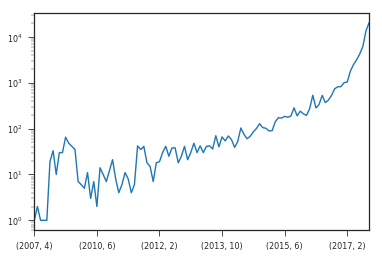

In [9]:
times.groupby([times.dt.year, times.dt.month]).count().plot()
plt.yscale('log')

In [10]:
hashtag_vectors = load_vectors("models/user_hashtag_docs.tsv")
mention_vectors = load_vectors("models/user_mention_docs.tsv")

In [11]:
def user_vectors(tweets_data, vector_data, label="hashtags"):
    """Returns a VectorDataTuple"""
    id2label = []
    vectors = []
    base_vector = np.zeros(vector_data.vectors.shape[-1])
    get_vector = lambda x: (vector_data.vectors[vector_data.label2id[x.lower()]]
                            if x.lower() in vector_data.label2id else base_vector)
    for screen_name, tweets in tweets_data.items():
        user_labels = sum((getattr(tweet, label)
                          for tweet in tweets if getattr(tweet, label)), ())
        user_vector = base_vector
        if user_labels:
            user_vector = np.sum(list(map(get_vector, user_labels)), axis=0)
        id2label.append(screen_name)
        vectors.append(user_vector)
        assert user_vector.shape == base_vector.shape, "Vector shape mismatch {}".format(user_vectors)
    label2id = {label:i for i, label in enumerate(id2label)}
    vectors = np.vstack(vectors)
    return VectorDataTuple(id2label, label2id, vectors)

In [12]:
user_hashtag_vectors = user_vectors(tweets_data, hashtag_vectors, label="hashtags")
user_mention_vectors = user_vectors(tweets_data, mention_vectors, label="mentions")

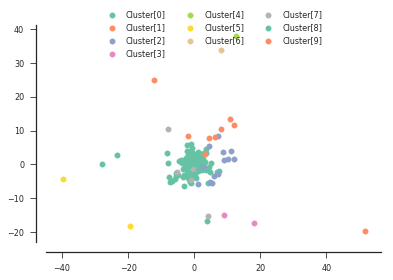

In [13]:
N_clusters = 10
user_hashtag_clusters = plot_clusters(KMeans(n_clusters=N_clusters), user_hashtag_vectors.vectors)

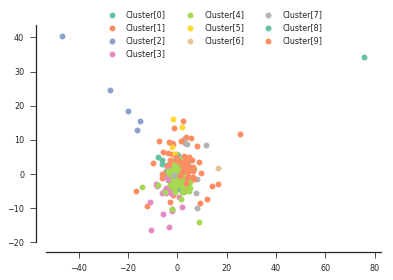

In [14]:
N_clusters = 10
user_mention_clusters = plot_clusters(KMeans(n_clusters=N_clusters), user_mention_vectors.vectors)

In [15]:
user_hashtag_clusters[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [16]:
def print_clusters(clusters, vectors, N=10):
    for cid in np.unique(clusters):
        user_names = list(vectors.id2label[i]
                         for i in range(clusters.shape[0]) if clusters[i] == cid)
        print("Cluster[{}]: {}".format(cid, ", ".join(user_names[:N])))

In [17]:
print_clusters(user_hashtag_clusters, user_hashtag_vectors, N=10)

Cluster[0]: avehtari, Dynamicland1, kjhealy, d3js_org, math3ma, jcjohnss, SamHarrisOrg, thejaan, haveibeenpwned, dataandme
Cluster[1]: fenicsproject
Cluster[2]: icmlconf, dataverseorg, hildaworkshop, fb_engineering, usnistgov, uspto, iuinfograd, IntelNervana, spark_summit, databricks
Cluster[3]: OpenVisConf, dbpedia
Cluster[4]: DataPortalIndia
Cluster[5]: AInsights, boredyannlecun
Cluster[6]: MindShiftKQED
Cluster[7]: KirkDBorne, opengovpart, OrangeDataMiner, Rbloggers, katycns
Cluster[8]: KaggleDatasets, DrRituRaman
Cluster[9]: ProjectOpenUP, TheContentMine, ACM_CSCW, openminted_eu, jcdl2016, wospworkshop, iSchools, iconf


In [18]:
print_clusters(user_mention_clusters, user_mention_vectors, N=10)

Cluster[0]: kjhealy, d3js_org, math3ma, jcjohnss, SamHarrisOrg, thejaan, haveibeenpwned, datassist, MonaChalabi, chiquiesteban
Cluster[1]: avehtari, KirkDBorne, NadiehBremer, sxywu, pythonbytes, oliviawalch, wesmckinn, GGorczynski, OpenVisConf, msalganik
Cluster[2]: i4oc_org, sparontologies, essepuntato, dshotton, opencitations
Cluster[3]: icmlconf, BKCHarvard, datasociety, project_thor_eu, datacite, rOpenSci, deviparikh, ProjectOpenUP, data4democracy, graphific
Cluster[4]: Dynamicland1, NUnetsi, syhw, SMLabTO, nlpandcss, jennifernvictor, Nigel_Shadbolt, teoliphant, PyData, ProjectJupyter
Cluster[5]: bayesimpact, kdd_news, talyarkoni, WebSciConf
Cluster[6]: MetaMindIO
Cluster[7]: CutTheKnotMath, mollyeroberts, adampaulcoates, Rspodcast, GateAcUk, escience, clipsua, spacy_io, POTUS
Cluster[8]: DataPortalIndia
Cluster[9]: dataandme, p5xjs, shiffman, StanfordCIS, GETillinois, brucedesmarais, clauwa, hadleywickham, kanarinka, jeremyphoward
